# EVOLUTIVE FDI (EFDI)

## START

### Imports

In [1]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler as sk_minmax
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import OrderedDict
from pprint import pprint
from river import anomaly, preprocessing, compose, ensemble, neighbors, datasets
from river.utils import numpy2dict
from sklearn.datasets import load_digits
from math import *

### Datasets

#### ImageSegments

In [106]:
# Carregando o CSV para DataFrame
dataset_original = pd.read_csv(datasets.ImageSegments().path)

#Realizando o LabelEncoder da variável dependente
dataset_original['categorical_label'] = LabelEncoder().fit_transform(dataset_original['category'])
dataset = dataset_original.copy()

dataset.pop('category')

data = {}
for k, prefix in enumerate(['FF', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6']):
    data[prefix] = dataset[dataset['categorical_label'] == k].iloc[:, :-1].to_numpy()
    data[prefix+'_train'] = data[prefix][0:99]
    data[prefix+'_test']  = data[prefix][99:330]

#### MNIST

In [2]:
# MNIST
digits = load_digits()
dataset_mnist = np.concatenate((digits.data,digits.target.reshape(-1,1)), axis=1)

data = {}
for k in np.arange(0,10):
    rate = 0.7
    prefix = 'F'+str(k)
    data[prefix] = dataset_mnist[dataset_mnist[:,64] == k][:, :-1]
    split = ceil(len(data[prefix])*rate)
    data[prefix+'_train'] = data[prefix][:split]
    data[prefix+'_test']  = data[prefix][split:]

## INITIAL PHASE

- Initialize DETECTOR algorithm with some Fault Free Samples
- Initialize CLASSIFIER algorithm with some Fault Mode samples (max 2)
- Initialize CLUSTERER algorithm

### Initialize DETECTOR

In [21]:
# OFFLINE PHASE

# Hiperparameter
threshold = 0.5

# Starting MinMax Scaler
minmax_scaler = sk_minmax()

# Starting the Model
model = compose.Pipeline(
    anomaly.HalfSpaceTrees(seed=42)
)

# INITIAL OFFLINE PHASE
for x in data['FF_train']:
    x_scaled = minmax_scaler.partial_fit(x.reshape(1, x.shape[0])).transform(x.reshape(1, x.shape[0]))
    model.learn_one(numpy2dict(x_scaled))

### Initialize Classifier

In [22]:
# OFF LINE PHASE
classifier = ensemble.BaggingClassifier(
    model=(
            preprocessing.MinMaxScaler() |
            neighbors.KNNADWINClassifier()
    )
)

# Training the classifier with some known classes
# Some Fault Mode (1,2,3,4) samples were chosen to initialize the classifier
for k in np.arange(1,5):
    for x in data['F'+str(k)+'_train']:
        classifier.predict_one(numpy2dict(x))
        classifier = classifier.learn_one(numpy2dict(x), k)

## DETECTOR PHASE

### SGD One Class SVM (Sk Learn)

In [47]:
from sklearn import linear_model
from sklearn.preprocessing import *
#X = np.array([[-2, -2], [-1, -1], [1, 1], [2, 2]])
model_sgd = linear_model.SGDOneClassSVM(random_state=42)
#clf.fit(X)
#print(clf.predict([[10000, 1000]]))
minmax_scaler = MinMaxScaler()

for x in np.concatenate((data['FF'],data['FF'],data['FF'],data['FF'])):
    x_scaled = minmax_scaler.partial_fit(x.reshape(1, x.shape[0])).transform(x.reshape(1, x.shape[0]))
    model_sgd.fit(x_scaled)

# DETECTOR ONLINE PHASE
# Validation with 70% Fault Free
x_val = data['FF_test']
inliers = 0

for x in x_val:
    x_scaled = minmax_scaler.transform(x.reshape(1, x.shape[0]))

    score = model_sgd.predict(x_scaled)

    if (score == 1): #1 inlier
        inliers = inliers+1

pprint(f'{inliers/len(x_val)*100:.2f}% samples has been identified as FAULT FREE')

# Test with all fault modes
x_test = np.concatenate(([data['F'+str(x)] for x in np.arange(1,7)]))
outliers = 0
outliers_map = []

for x in x_test:
    x_scaled = minmax_scaler.transform(x.reshape(1, x.shape[0]))
    score = model_sgd.predict(x_scaled)

    if (score == -1): #-1 outlier
        outliers = outliers+1
        outliers_map.append(np.array(x).tolist())

    # if anomaly -> revert scaler -> send to Classifier Phase

pprint(f'{outliers/len(x_test)*100:.2f}% samples has been identified as ANOMALY')

'45.45% samples has been identified as FAULT FREE'
'61.67% samples has been identified as ANOMALY'


### HalfSpaceTree (RIVER)

In [113]:
# DETECTOR ONLINE PHASE

# Validation with 70% Fault Free
x_val = data['FF_test']
# Test with all fault modes
x_test = np.concatenate(([data['F'+str(x)] for x in np.arange(1,7)]))
inliers = 0
outliers = 0
outliers_map = []

for x in x_val:
    x_scaled = minmax_scaler.transform(x.reshape(1, x.shape[0]))

    score = model.score_one(numpy2dict(x_scaled[0]))

    if (score <= threshold): #low score - normal observation
        inliers = inliers+1

pprint(f'{inliers/len(x_val)*100:.2f}% samples has been identified as FAULT FREE')


for x in x_test:
    x_scaled = minmax_scaler.transform(x.reshape(1, x.shape[0]))
    score = model.score_one(numpy2dict(x_scaled[0]))

    if (score > threshold): #high score - outlier observation
        outliers = outliers+1
        outliers_map.append(np.array(x).tolist())

    # if anomaly -> revert scaler -> send to Classifier Phase

pprint(f'{outliers/len(x_test)*100:.2f}% samples has been identified as ANOMALY')

'0.00% samples has been identified as FAULT FREE'
'85.91% samples has been identified as ANOMALY'


### HalfSpace Tree (Sk Flow)

In [20]:
from skmultiflow.data import AnomalySineGenerator
stream = AnomalySineGenerator(random_state=1, n_samples=1000, n_anomalies=10)
n_samples = 0
X_ = np.empty([1, 2])
Y_ = np.empty([1])
while n_samples < 1000 and stream.has_more_samples():
    X, y = stream.next_sample()
    X_ = np.concatenate((X_, X))
    Y_ = np.concatenate((Y_, y))
    n_samples += 1

In [27]:
X_df = pd.DataFrame(X_)
X_df['y'] = Y_

normal = X_df[X_df['y'] == 0].iloc[:,:-1].to_numpy()
anormal = X_df[X_df['y'] == 1].iloc[:,:-1].to_numpy()

In [29]:
from skmultiflow.anomaly_detection import HalfSpaceTrees

def hst(hst_sf, data_NORMAL, data_ANORMAL):
    print(hst_sf)
    # INITIAL OFFLINE PHASE
    for x in data_NORMAL:
        hst_sf.predict(x.reshape(1, 2))
        hst_sf.partial_fit(x.reshape(1, 2))

    inliers = 0
    for x in data_NORMAL:
        x = x.reshape(1, 2)
        y_hat = hst_sf.predict(x)[0]
        if y_hat == 0:
            inliers = inliers+1

    print(inliers/len(data_NORMAL))

    outliers = 0
    c = 0
    for x in np.concatenate((data_ANORMAL, data_NORMAL[0:50])):
        c = c+1
        x = x.reshape(1, 2)
        y_hat = hst_sf.predict(x)[0]
        if y_hat == 1:
            outliers = outliers+1
            #print(hst_sf.predict_proba(x))

    print(outliers/c)

estimators = [3, 5, 10, 20, 30, 40, 50, 60]
window = [10, 25, 50, 75, 100, 150]
size = [10, 20, 30, 40, 50, 60]
depth = [15, 20, 25, 30, 35, 40, 50]

for e in estimators:
    for w in window:
        for s in size:
            for d in depth:
                hst(HalfSpaceTrees(n_estimators=e, window_size=w, size_limit=s, depth=d), normal, anormal)



HalfSpaceTrees(anomaly_threshold=0.5, depth=15, n_estimators=3,
               random_state=None, size_limit=10, window_size=10)
0.0
1.0
HalfSpaceTrees(anomaly_threshold=0.5, depth=20, n_estimators=3,
               random_state=None, size_limit=10, window_size=10)
0.0
1.0
HalfSpaceTrees(anomaly_threshold=0.5, depth=25, n_estimators=3,
               random_state=None, size_limit=10, window_size=10)


KeyboardInterrupt: 

In [10]:
# Imports
from skmultiflow.data import AnomalySineGenerator
from skmultiflow.anomaly_detection import HalfSpaceTrees
# Setup a data stream
stream = AnomalySineGenerator(random_state=1, n_samples=1000, n_anomalies=250)
# Setup Half-Space Trees estimator
half_space_trees = HalfSpaceTrees(random_state=1)
# Setup variables to control loop and track performance
max_samples = 1000
n_samples = 0
true_positives = 0
detected_anomalies = 0
# Train the estimator(s) with the samples provided by the data stream
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    y_pred = half_space_trees.predict(X)
    if y[0] == 1:
        true_positives += 1
        if y_pred[0] == 1:
            detected_anomalies += 1
    half_space_trees.partial_fit(X, y)
    n_samples += 1
print('{} samples analyzed.'.format(n_samples))
print('Half-Space Trees correctly detected {} out of {} anomalies'.
      format(detected_anomalies, true_positives))

1000 samples analyzed.
Half-Space Trees correctly detected 157 out of 220 anomalies


In [1]:


for x in x_val:
    x_scaled = minmax_scaler.transform(x.reshape(1, x.shape[0]))

    score = hst_sf.predict_proba(x_scaled[0])
    print(score)
    break
    #if (score <= threshold): #low score - normal observation
    #    inliers = inliers+1

pprint(f'{inliers/len(x_val)*100:.2f}% samples has been identified as FAULT FREE')


for x in x_test:
    x_scaled = minmax_scaler.transform(x.reshape(1, x.shape[0]))
    score = hst_sf.predict_proba(x_scaled[0])

    if (score > threshold): #high score - outlier observation
        outliers = outliers+1
        outliers_map.append(np.array(x).tolist())

    # if anomaly -> revert scaler -> send to Classifier Phase

pprint(f'{outliers/len(x_test)*100:.2f}% samples has been identified as ANOMALY')


NameError: name 'x_val' is not defined

### MLP Classifier (Sk Learn) with Gausian Noise


In [8]:
from sklearn.neural_network import MLPClassifier

def mlp_train(train, validation, test, max_iter, activation, hidden_layer_sizes, solver, alpha, learning_rate, scaler, threshold=0.7):
    model_str = str(activation) + ';'+str(hidden_layer_sizes) + ';'+str(solver) + ';' + str(alpha) + ';'+str(learning_rate)+ ';'+str(scaler)+ ';'+str(threshold)

    y_train = [0] * len(train)

    X_noise = np.random.normal(0,1, train.shape[0] * train.shape[1]).reshape(train.shape[0], train.shape[1])
    y_noise = [-1] * len(train)

    clf = MLPClassifier(random_state=42, max_iter=max_iter, activation=activation, hidden_layer_sizes=hidden_layer_sizes, solver=solver, alpha=alpha, learning_rate=learning_rate)

    clf.partial_fit(np.concatenate((scaler.partial_fit(train[:1]).transform(train[:1]), X_noise[:1])), np.concatenate((y_train[:1], y_noise[:1])), classes=np.array([-1,0]))

    for k, x in enumerate(train):
        scaled = scaler.partial_fit(train[k:k+1]).transform(train[k:k+1])
        clf.partial_fit(np.concatenate((scaled, X_noise[k:k+1])), np.concatenate((y_train[k:k+1], y_noise[k:k+1])))

    inliers = 0
    for k, x in enumerate(validation):
        x_scaled = scaler.transform(x.reshape(1, x.shape[0]))
        y_hat = clf.predict(x_scaled)
        y_hat_proba = clf.predict_proba(x_scaled)

        if (y_hat[0] == 0 and y_hat_proba[0][1] >= threshold): ## NORMAL com com alta confiança
            inliers = inliers+1

    outliers = 0
    for k, x in enumerate(test):
        x_scaled = scaler.transform(x.reshape(1, x.shape[0]))
        y_hat = clf.predict(x_scaled)
        if (y_hat[0] == -1):
            outliers = outliers+1
        else:
            y_hat_proba = clf.predict_proba(x_scaled)
            if (y_hat_proba[0][1] < threshold): # predict as inliers but with low confidence => is outlier!
                outliers = outliers+1
            else:
                pass # inlier ++

    #if ((inliers / len(validation) > 0.7) and (outliers / len(test) > 0.6)):
    print(model_str + ';' + str(inliers / len(validation)) + ';' + str(outliers / len(test)))

    return clf, scaler

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

train = np.concatenate((data['FF_train'],data['FF_train'],data['FF_train'],data['FF_train']))
validation = data['FF_test']
test = np.concatenate((data['F1'], data['F2'],data['F3'], data['F4'],data['F5'], data['F6']))

parameter_space = {
    'hidden_layer_sizes': [(500, 200, 100), (50,50,50), (50,100,50), (100,)],
    'activation': ['logistic', 'identity', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'scaler': [MinMaxScaler(), StandardScaler()],
    'threshold': [.9, .8, .7, .6, .5]
}

threshold = .7

parameter_space = {
    'hidden_layer_sizes': [(500, 200,100)],
    'activation': ['tanh'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['adaptive'],
    'scaler': [StandardScaler()],
    'threshold': [threshold]
}

for hls in parameter_space['hidden_layer_sizes']:
    for act in parameter_space['activation']:
        for s in parameter_space['solver']:
            for a in parameter_space['alpha']:
                for lr in parameter_space['learning_rate']:
                    for scl in parameter_space['scaler']:
                        for t in parameter_space['threshold']:
                            clf, scaler = mlp_train(train, validation, test, max_iter=1000, hidden_layer_sizes=hls, activation=act, solver=s, alpha=a, learning_rate=lr, scaler=scl, threshold=t)

tanh;(500, 200, 100);adam;0.0001;adaptive;StandardScaler();0.7;0.9264069264069265;0.5171717171717172


In [30]:
ff = pd.DataFrame(data['FF'])
ff['y'] = [0] * len(ff)

f = pd.DataFrame(np.concatenate((data['F1'],data['F2'],data['F3'],data['F4'],data['F5'],data['F6'])))
f['y'] = [-1] * len(f)

all_data = np.concatenate((ff.to_numpy(), f.to_numpy()[:len(ff)]))

In [33]:
from sklearn.metrics import accuracy_score

ground_truth = all_data[:, -1]
predicts = []

for x in all_data[:, :-1]:
    y_hat = clf.predict(scaler.transform(x.reshape(1, x.shape[0])))
    y_hat_proba = clf.predict_proba(scaler.transform(x.reshape(1, x.shape[0])))

    x_scaled = scaler.transform(x.reshape(1, x.shape[0]))
    y_hat = clf.predict(x_scaled)
    y_hat_proba = clf.predict_proba(x_scaled)

    if (y_hat[0] == 0 and y_hat_proba[0][1] >= threshold):
        predicts.append(0)
    else:
        predicts.append(-1)

accuracy_score(ground_truth, predicts)

0.8

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ground_truth, predicts, normalize='true')
print(cm)


[[0.78787879 0.21212121]
 [0.18787879 0.81212121]]


0.3469387755102041

### Rede Neural com Ruído Gaussiano (PyTorch)

In [72]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
import math
import torch
from torch import nn
import numpy as np
from sklearn.metrics import confusion_matrix

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

def train(net, train_loader, num_epochs, optimizer, loss_function):
    for epoch in range(num_epochs):
        for n, (real_samples, _) in enumerate(train_loader):

            net.zero_grad()

            # train
            output = net(real_samples.type(torch.FloatTensor))

            a = []
            for x in _:
                if x == 0:
                    a.append([0.0]) #normal
                else:
                    a.append([1.0]) #fault

            loss = loss_function(
                output, torch.from_numpy(np.array(a).astype(np.float32)))

            # update weights
            loss.backward()
            optimizer.step()

    return net

def get_fault_free_train_set(data, scaler, batch_size):
    size = math.floor(len(data)/batch_size)*batch_size
    data = data[:size]
    data_sc = scaler.fit_transform(data)
    labels_ff = torch.from_numpy(np.array([0]*size).astype(np.float32))

    noise = np.random.normal(0,1, data.shape[0] * data.shape[1]).reshape(data.shape[0], data.shape[1])
    labels_noise = torch.from_numpy(np.array([1]*size).astype(np.float32))

    train_set = [
        (np.concatenate((data_sc, noise))[i], torch.cat((labels_ff, labels_noise))[i]) for i in range(len(data_sc) + len(noise))
    ]

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True
    )

    return train_loader, scaler

In [121]:
# main
net = Net()
lr = 0.001
num_epochs = 300
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss_function = nn.BCELoss()
batch_size = 16
torch.manual_seed(111)
ss = StandardScaler()

In [134]:
#TRAIN
are_normal = [0]

for label in are_normal:
    idx = 'F'+str(label)+'_train'
    # join to gaussian noise
    tl, ss = get_fault_free_train_set(data[idx], ss, batch_size)
    # train
    net = train(net, tl, num_epochs, optimizer, loss_function)

In [142]:
# PREDICT
r = net(torch.from_numpy(ss.transform(data['F0_test']).astype(np.float32)))

In [143]:
y_hat = []
for x in r.cpu().detach().numpy() < 0.5:
    if x:
        y_hat.append(0)
    else:
        y_hat.append(1)

ground_truth = []
for x in [0]*len(data['F0_test']):
    if x in are_normal:
        ground_truth.append(0)
    else:
        ground_truth.append(1)

cm = confusion_matrix(ground_truth, y_hat, normalize='true')
print(cm)

[[0.9245283 0.0754717]
 [0.        0.       ]]


### Autoencoder (PyTorch)

In [6]:
#!pip install fastai
from sklearn.preprocessing import StandardScaler
import math
import torch
from torch import nn
import numpy as np
from sklearn.metrics import confusion_matrix
from torchvision import transforms
from fastai.vision.all import show_image
import matplotlib.pyplot as plt

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


Bad key "text.kerning_factor" on line 4 in
C:\Users\MARCELO\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [5]:
def train(net, train_loader, num_epochs, optimizer, loss_function):
    train_loss = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for n, (real_samples, _) in enumerate(train_loader):

            net.zero_grad()

            ### forward ###
            output = net(real_samples.type(torch.FloatTensor))

            loss = loss_function(
                output, real_samples.type(torch.FloatTensor)
            )
            running_loss += loss.item()

            ### backward ###
            loss.backward()
            optimizer.step()

        step_loss = running_loss / len(train_loader)
        train_loss.append(step_loss)
        ### log ###
        #print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss))

    return net, output, train_loss

In [7]:
# main
net = Autoencoder()
lr = 1e-3
num_epochs = 50
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)
loss_function = nn.MSELoss()
batch_size = 32
torch.manual_seed(111)
ss = StandardScaler()

In [8]:
data_ss_ae = ss.fit_transform(data['F0_train'])

train_set = [
    (data_ss_ae[i], data_ss_ae[i]) for i in range(len(data_ss_ae))
]
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [97]:
net, output, loss = train(net, train_loader, num_epochs, optimizer, loss_function)

Text(0, 0.5, 'Loss')

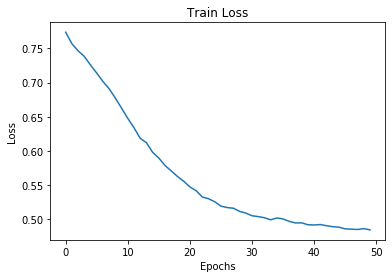

In [98]:
plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [99]:
loss[-1]

0.48402226716279984

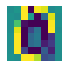

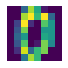

In [70]:
show_image(output[0].reshape((8,8)))
show_image(data['F0'][0].reshape((8,8)))

In [104]:
y_hat = []
ground_truth = []
keys = ['F0_test', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']
for key in keys:
    for k, x in enumerate(data[key]):
        if key == 'F0_test':
            ground_truth.append(0)
        else:
            ground_truth.append(1)

        real = ss.transform(x.reshape(1,-1)).astype(np.float32)

        regenerate = net(torch.from_numpy(real))

        loss = loss_function(regenerate, torch.from_numpy(real)).cpu().detach().numpy()

        if loss < 2:
            y_hat.append(0)
        else:
            y_hat.append(1)


confusion_matrix(ground_truth, y_hat, normalize='true')

array([[0.98113208, 0.01886792],
       [0.        , 1.        ]])

### OneClass SVM | IF | LOF (SkLearn)

- Supervised algorithms as an Baseline
- Could be compared with the previous indicators
- Good results

In [119]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

def verify(model, inliers, outliers):
    print(model)
    inliers_detected = 0
    for k, x in enumerate(inliers):
        if (x == 1):
            inliers_detected = inliers_detected+1

    pprint('Identificou ' + str(inliers_detected/len(inliers)*100) + '% de amostras normais corretamente')

    outliers_detected = 0
    for k, x in enumerate(outliers):
        if (x == -1):
            outliers_detected = outliers_detected+1

    pprint('Identificou ' + str(outliers_detected/len(outliers)*100) + '% de amostras de falhas corretamente')
    print('********')

clfs = [
    OneClassSVM(gamma='auto').fit(data['FF_train']),
    IsolationForest(random_state=0).fit(data['FF_train']),
    LocalOutlierFactor(n_neighbors=2, novelty=True).fit(data['FF_train']),
]

for k, clf in enumerate(clfs):
    verify(clf, clf.predict(data['FF_test']), clf.predict(np.concatenate(([data['F'+str(x)] for x in np.arange(1,7)]))))


OneClassSVM(gamma='auto')
'Identificou 2.1645021645021645% de amostras normais corretamente'
'Identificou 100.0% de amostras de falhas corretamente'
********
IsolationForest(random_state=0)
'Identificou 75.32467532467533% de amostras normais corretamente'
'Identificou 100.0% de amostras de falhas corretamente'
********
LocalOutlierFactor(n_neighbors=2, novelty=True)
'Identificou 87.87878787878788% de amostras normais corretamente'
'Identificou 93.73737373737374% de amostras de falhas corretamente'
********


### Send to Classifier

- Get all samples classified as ANOMALY and send to CLASSIFIER PHASE

In [16]:
pprint(len(outliers_map))

1500


## CLASSIFIER PHASE

### KNN ADWIN_CLASSIFIER (RIVER)


In [107]:
# Evaluation
# qty UNK -> K (misclassified)
# qty UNK -> UNK (ok)
# UNK -> UNK send to Clusterer Phase
# At this point, the framework only known F1 Fault Mode. The another classes must be classified as Unknown and send to Clusterer Phase.

threshold = 0.95
classified_as_known = 0
DATASET_3 = []

new_class = data['F6_test']

# Testando o classificador com a nova classe (PATH)
for idx, x in enumerate(new_class):
    y_pred_proba = classifier.predict_proba_one(numpy2dict(x))

    max_proba = max(y_pred_proba.items(), key = lambda k : k[1])
    if (max_proba[1] < threshold): #indecisao
        DATASET_3.append(idx)
    else: #certeza
        classified_as_known = classified_as_known + 1

print('as know {:.2f}% : as unknown {:.2f}%'.format(classified_as_known/len(new_class)*100, len(DATASET_3)/len(new_class)*100))

as know 57.14% : as unknown 42.86%


### SCIKIT_MULTIFLOW KNN (SkFlow)


In [108]:
from skmultiflow.lazy import KNNClassifier

classifier_knn_sk_mult = KNNClassifier()

# Treinando o classificador com as classes conhecidas
for x in data['F3_test']:
    classifier_knn_sk_mult = classifier_knn_sk_mult.partial_fit(x.reshape(1, x.shape[0]), [3])

for x in data['F2_test']:
    classifier_knn_sk_mult = classifier_knn_sk_mult.partial_fit(x.reshape(1, x.shape[0]), [2])

for x in data['F4_test']:
    classifier_knn_sk_mult = classifier_knn_sk_mult.partial_fit(x.reshape(1, x.shape[0]), [4])

classifier_knn_sk_mult.predict_proba(data['FF_test'][59].reshape(1, x.shape[0]))

array([[0., 0., 1., 0., 0.]])

## CLUSTERER

### 1 Cluster

In [33]:
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler

# precisa ser INCREMENTAL PCA
# precisa ser INCREMENTAL StandardScaler

pca = PCA(.95)

S2_1_cluster_pca = pd.DataFrame(pca.fit_transform(S2_1_DATASET_3).tolist())

S2_1_cluster_pca_ss = StandardScaler().fit_transform(S2_1_cluster_pca.to_numpy())

#### Incremental DBSTREAM


In [16]:
from river import cluster

y_pred_dbstream = []
dbstream = cluster.DBSTREAM(clustering_threshold = 2)

for x in S2_1_cluster_pca_ss:
    dbstream.learn_one(numpy2dict(x))
    y_pred_dbstream.append(dbstream.predict_one(numpy2dict(x)))

res =  [(el, y_pred_dbstream.count(el)) for el in y_pred_dbstream]
y_pred_dbstream_grouped = list(OrderedDict(res).items())
print(dbstream.n_clusters)

9


#### DenStream

In [17]:
denstream = cluster.DenStream()

y_pred_denstream = []
for x in S2_1_cluster_pca_ss:
    denstream.learn_one(numpy2dict(x))

for x in S2_1_cluster_pca_ss:
    y_pred_denstream.append(denstream.predict_one(numpy2dict(x)))

print(denstream.n_clusters)

1


#### DBSCAN

In [18]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(metric='manhattan').fit(S2_1_cluster_pca_ss)

dbscan_labels_list = dbscan.labels_.reshape(1, dbscan.labels_.shape[0]).tolist()[0]

res =  [(el, dbscan_labels_list.count(el)) for el in dbscan_labels_list]
y_pred_dbscan_grouped = list(OrderedDict(res).items())

print('Qtd Labels DBSCAN offline: ' + str(len(np.unique(dbscan.labels_))))

Qtd Labels DBSCAN offline: 6


#### TEDA Cloud

In [19]:
import numpy as np
import math
from numpy import linalg as LA
from scipy.spatial import distance


#### CLOUD ####
class Cloud:

    def __init__(self, sample=[], name='Default Class'):
        self.name = name
        self.var = 0
        self.n = 0
        self.covmat = []

        if (len(sample) > 0):
            self.mean = sample
            self.n = 1
            self.covmat = np.zeros((sample.shape[0], sample.shape[0]))

    def updateCloud(self, mu=[], var=0, n=0, covmat=[]):
        self.mean = mu
        self.var = var
        self.n = n
        self.covmat = covmat

    def addPoint(self, sample=[]):
        if (self.n == 0):
            self.n = 1
            self.mean = sample
            self.var = 0
            self.covmat = np.zeros((self.mean.shape[0], self.mean.shape[0]))
        else:
            self.n = self.n + 1
            self.mean = self.calculate_mean(sample, self.n)
            self.var = self.calculate_variance(sample, self.n, self.mean)
            self.covmat = self.calculate_variance_matrix(sample, self.n, self.mean)


    def calculateZeta(self, sample=[], similarity_measure='euclidean'):
        if self.n == 0:
            zeta = math.inf
            return zeta

        n_ = self.n + 1
        mean_ = self.calculate_mean(sample, n_)
        var_ = self.calculate_variance(sample, n_, mean_)
        covmat_ = self.calculate_variance_matrix(sample, n_, mean_)


        if (similarity_measure.lower() == 'euclidean'):
            ksi = np.maximum(self.calculate_eccentricity(sample, self.n, mean_, var_), 0.0001)
        else:
            ksi = np.maximum(self.calculate_eccentricity(sample, n_, mean_, var_, covmat_, 'mahalanobis'), 0.0001)

        zeta = ksi / 2
        return zeta

    def calculate_mean(self, sample, n):
        return ((n - 1) / n) * self.mean + (1 / n) * sample

    def calculate_variance(self, sample, n, mean):
        return ((n - 1) / n) * self.var + (1 / (n)) * LA.norm(sample - mean) ** 2

    def calculate_variance_matrix(self, sample, n, mean):
        a = (n - 1) / n
        b = a * self.covmat
        c = [sample - mean]
        d = np.transpose(c)
        e = (1 / n) * d    ##TALVEZ SEJA 1 / (n-1)

        f = b + e * c

        return f

    def calculate_eccentricity(self, sample, n, mean, variance, covmat = [], similarity_measure = 'euclidean'):

        a = 1 / n

        if (similarity_measure == 'euclidean'):
            b = [mean - sample]
            c = np.transpose(b)
            d = n * variance
            e = np.dot(b, c)
            f = e / d

            r = distance.euclidean(sample, mean)

            ksi = a + f
        else: # mahalanobis_formula => (sample - mean).T * covmat*-1 * (sample - mean)

            d_mahalanobis = np.zeros((1,1), dtype=float) + distance.mahalanobis(mean, sample, LA.pinv(covmat))**2

            h = n * len(mean) #nao entendi para que isso - parece a ponderacao do n elementos pela qtd de dimensoes
            m = d_mahalanobis / h

            ksi = a + m

        return ksi

###########################################################################
###########################################################################
################################ AUTOCLOUD ################################
###########################################################################
###########################################################################
class AutoCloud:

    def __init__(self, m = 2, similarity_measure = 'euclidean', auto_merge = True, display = False):
        self.k = 0
        self.cloudList = []
        self.predictions = {}
        self.predictions_by_sample = {}
        self.initialize_intersection_list()
        self.initialize_intersection_matrix()
        self.contMerge = 0
        self.dimension = 0
        self.similarityMeasure = similarity_measure
        self.autoMerge = auto_merge
        self.m = m
        self.display = display

    def run(self, sample = [], label = None):

        if (self.dimension == 0):
            self.dimension = sample.shape[0]
        else:
            if (self.dimension != sample.shape[0]):
                raise Exception('The dimension of the current data sample is different from the points read so far.')

        if (label != None): #para supervisionado - aqui temos também o Y (label) da amostra

            while (len(self.cloudList) < label): #cria a qtd de classes
                self.create_cloud(sample)

            self.cloudList[label - 1].addPoint(sample)
            self.k = self.k + 1

            self.initialize_intersection_list()
            self.membershipList = [0] * len(self.cloudList)
            self.membershipList[label - 1] = 1
            self.intersectionList[label - 1] = 1
            self.initialize_intersection_matrix()

            return label, self.membershipList

        else:
            self.k = self.k + 1
            self.initialize_intersection_list()

            if (self.k == 1):
                self.cloudList.append(Cloud(sample = sample, name = 'Class 1'))
                self.initialize_intersection_list()
                self.initialize_intersection_matrix()
                self.membershipList = [1]
            elif (self.k == 2):
                self.cloudList[0].addPoint(sample)
                self.membershipList = [1]
            elif (self.k >= 3):
                createCloud = True
                tauList = np.zeros((len(self.cloudList), 1))

                for i_cloud, cloud in enumerate(self.cloudList):
                    zeta = cloud.calculateZeta(sample, self.similarityMeasure) #??eccentricity | ?? norm_eccentricity
                    tau = 1 - zeta #??typicality
                    tauList[i_cloud] = tau

                    if (self.calculate_sample_belongs_to_cloud(zeta, cloud.n)):
                        cloud.addPoint(sample)
                        self.intersectionList[i_cloud] = 1
                        createCloud = False
                    else:
                        self.intersectionList[i_cloud] = 0

                self.membershipList = tauList / sum(tauList)

                ### NEW CLOUD ###
                if (createCloud == True):
                    self.create_cloud(sample)

        amax = np.amax(self.membershipList)
        where = np.where(self.membershipList == amax)
        y_label = where[0][0]+1

        if (self.autoMerge):
            self.mergeClouds()

        return y_label, self.membershipList

    def mergeClouds(self):
        i = 0

        i_end = len(self.cloudList) - 1
        while (i < i_end):

            merge = False

            j_end = np.arange(i + 1, len(self.cloudList)).reshape(-1)
            for j in j_end:
                if (self.intersectionList[i] == 1 and self.intersectionList[j] == 1):
                    self.intersectionMatrix[i,j] = self.intersectionMatrix[i,j] + 1

                ### recover information about clouds to be merged ###
                n_i = self.cloudList[i].n
                n_j = self.cloudList[j].n
                mean_i = self.cloudList[i].mean
                mean_j = self.cloudList[j].mean
                var_i = self.cloudList[i].var
                var_j = self.cloudList[j].var
                covmat_i = self.cloudList[i].covmat
                covmat_j = self.cloudList[j].covmat
                nint = self.intersectionMatrix[i,j]

                if (nint > (n_i - nint) or nint > (n_j - nint)):
                    ### merge
                    if (self.display):
                        print('Merging clouds ' + str(i+1) + ' and ' + str(j+1) + ' at instant ' + str(self.k))
                    ### calculate state of new cloud
                    n = n_i + n_j - nint
                    mean = ((n_i * mean_i) + (n_j * mean_j)) / (n_i + n_j)
                    var = ((n_i - 1) * var_i + (n_j - 1) * var_j) / (n_i + n_j - 2)
                    covmat = ((n_i - 1) * covmat_i + (n_j - 1) * covmat_j) / (n_i + n_j - 2)
                    ### create new cloud cloud ###
                    newCloud = Cloud()
                    newCloud.updateCloud(mean, var, n, covmat)
                    newCloud.name = 'Class ' + str(i+1) + '/' + str(j+1)

                    ### update intersection list ###
                    v_il1 = self.intersectionList[0: i]
                    v_il2 = np.array([1])
                    v_il3 = self.intersectionList[i + 1: j]
                    v_il4 = self.intersectionList[j + 1: np.size(self.intersectionList)]
                    self.intersectionList = np.concatenate((v_il1, v_il2, v_il3, v_il4), axis=None)

                    ## update cloud list ###
                    if (self.display):
                        print("Cloud (label) : " + str(i))
                    v_c1 = self.cloudList[0: i]
                    v_c2 = np.array([newCloud])
                    v_c3 = self.cloudList[i + 1: j]
                    v_c4 = self.cloudList[j + 1: np.size(self.cloudList)]
                    self.cloudList = np.concatenate((v_c1, v_c2, v_c3, v_c4), axis=None)

                    ### update intersection matrix ###
                    A = self.intersectionMatrix

                    #remover linha
                    vb1_0 = A[0: i, :]
                    vb2 = np.zeros((1, len(A)))
                    vb3 = A[i + 1: j, :]
                    vb4 = A[j + 1: len(A), :]
                    B = np.concatenate(([vb1_0, vb2, vb3, vb4]))

                    #remover coluna
                    vb1_1 = B[:, 0: i]
                    vb2 = np.zeros((len(B), 1))
                    vb3 = B[:, i + 1: j]
                    vb4 = B[:, j + 1: len(A)] ### acho que deveria ser LEN de B
                    B = np.concatenate(([vb1_1, vb2, vb3, vb4]), axis=1)

                    # calc nova coluna
                    col = (A[:, i] + A[:, j]) * (A[:, i] * A[:, j] != 0)
                    C = np.concatenate((col[0: j], col[j + 1: np.size(col)]))

                    # calc nova linha
                    lin = (A[i, :] + A[j, :]) * (A[i, :] * A[j, :] != 0)
                    L = np.concatenate((lin[0: j], lin[j + 1: np.size(lin)]))

                    #atualizar coluna
                    B[:,i] = C

                    #atualizar linha
                    B[i,:] = L

                    vb1_2 = A[[i], i+1 : j]
                    vb2 = A[i+1 : j, [j]]
                    vb3 = np.transpose(vb2)

                    B[[i], i+1 : j] = vb1_2 + vb3

                    self.intersectionMatrix = B

                    merge = True
                    self.contMerge = self.contMerge + 1
                    break

            if (merge == True):
                i = 1
            else:
                i = i + 1


    def initialize_intersection_matrix(self):
        if (len(self.cloudList) == 0):
            self.intersectionMatrix = np.zeros((1, 1))
        else:
            self.intersectionMatrix = np.zeros((len(self.cloudList), len(self.cloudList)))

    def initialize_intersection_list(self):
        if (len(self.cloudList) == 0):
            self.intersectionList = []
        else:
            self.intersectionList = [0] * len(self.cloudList)


    def calculateThreshold(self, s=None):
        if (self.similarityMeasure.lower() == 'euclidean'):
            th = (self.m ** 2 + 1) / (2 * (s))
        else:
            if (self.similarityMeasure.lower() == 'mahalanobis'):
                th = (self.m ** 2 + self.dimension) / (2 * (s) * self.dimension)

        threshold = th
        return threshold

    def create_cloud(self, sample):
        cloud_number = len(self.cloudList) + 1
        if (self.display):
            print('Creating cloud ' + str(cloud_number) + ' at instant ' + str(self.k))

        self.cloudList = np.append(self.cloudList, [Cloud(sample, 'Class ' + str(cloud_number))], axis=0)
        self.intersectionList.append(1)
        self.expand_intersection_matrix_with_zeros()

    def calculate_sample_belongs_to_cloud(self, zeta, cloud_n):
        return (zeta < math.inf and zeta <= self.calculateThreshold(cloud_n))

    def expand_intersection_matrix_with_zeros(self):
        self.intersectionMatrix = np.pad(self.intersectionMatrix, ((0, 1), (0, 1)), mode='constant', constant_values=0)

In [2]:
clusterer = AutoCloud(2, 'mahalanobis')

output = [0] * (S2_1_cluster_pca_ss.shape[0])

for k, sample in pd.DataFrame(S2_1_cluster_pca_ss).iterrows():
    y, _ = clusterer.run(sample)
    output.append(y)

print(len(np.unique(output)))

NameError: name 'AutoCloud' is not defined

### 2 Clusters

- Cluster class 1 , 4 (foliage, path)

In [ ]:
pca = PCA(.95)

S2_1_4_cluster_pca = pd.DataFrame(pca.fit_transform(pd.concat([S2_1_DATASET_3,S1_1[S1_1['categorical_label'] == 1].iloc[0:94, :-1]])).tolist())

S2_1_4_cluster_pca_ss = StandardScaler().fit_transform(S2_1_4_cluster_pca.to_numpy())

#### DBSTREAM

In [ ]:
from river import cluster

y_pred_dbstream = []
dbstream_1_4 = cluster.DBSTREAM(clustering_threshold = 2)

for x in S2_1_4_cluster_pca_ss:
    dbstream_1_4.learn_one(numpy2dict(x))
    y_pred_dbstream.append(dbstream_1_4.predict_one(numpy2dict(x)))

print(dbstream_1_4.n_clusters)

#### DenStream

In [ ]:
denstream_1_4 = cluster.DenStream()

y_pred_denstream = []
for x in S2_1_4_cluster_pca_ss:
    denstream_1_4.learn_one(numpy2dict(x))

for x in S2_1_4_cluster_pca_ss:
    y_pred_denstream.append(denstream_1_4.predict_one(numpy2dict(x)))

print(denstream_1_4.n_clusters)

#### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

dbscan_1_4 = DBSCAN(metric='chebyshev').fit(S2_1_4_cluster_pca_ss)

print('Qtd Labels DBSCAN offline: ' + str(len(np.unique(dbscan_1_4.labels_))))
print(dbscan_1_4.labels_)

#### TEDA Cloud

In [ ]:
autocloud_1_4 = AutoCloud(2, 'mahalanobis')

output = [0] * (S2_1_4_cluster_pca_ss.shape[0])

for k, sample in pd.DataFrame(S2_1_4_cluster_pca_ss).iterrows():
    y, _ = autocloud_1_4.run(sample)
    output.append(y)

print(len(np.unique(output)))

### INCREMENTAL CLASSIFIER

#### clusterer DBSTREAM -> CLASSIFIER

In [0]:
## COPIEI O CONTEUDO DO ENDPOINT KNOWN E VOU FAZER NA MÃO
## POIS NAO TERIA COMO REVERTER O PCA, POIS NÃO TENHO A
## REFERENCIA NO ARQUIVO _INIT_.PY

slice_factor = 0.2

# parameters
cluster = 3
_class = 35

# obter centro cluster 0
# obter samples do cluster 0
# calcular os __slice_factor__ mais proximos
# identificar que sao os samples no vetor original pré PCA e SS (posso utilizar o DB como apoio)
# enviar os samples para o CLASSIFICADOR

In [ ]:
#obter centro do cluster X
cluster_center = dbstream.centers[cluster]

In [ ]:
from scipy.spatial import distance
from river.utils import dict2numpy
import math

# pegar as keys dos samples para o cluster selecionado
cluster_key_samples = [key for key, value in enumerate(y_pred_dbstream) if value == cluster]

# pegar os samples para o cluster selecionado
cluster_samples = S2_1_cluster_pca_ss[cluster_key_samples]

# calcular distancias para cada sample
distances = []
for sample in cluster_samples:
    distances.append(distance.euclidean(dict2numpy(cluster_center), sample))

distances_unsorted = distances.copy()
distances.sort()

qty_distances_retrieve = math.ceil(len(distances) * slice_factor)
distances_retrieve = distances[: qty_distances_retrieve]

closest_samples_keys = [idx for idx, element in enumerate(distances_unsorted) if element in distances_retrieve]

#x = [cluster_samples[k] for k in closest_samples_keys]

#cluster_key_samples[[closest_samples_keys]]
cluster_key_samples_closest = [cluster_key_samples[v] for k, v in enumerate(closest_samples_keys)]

S2_1_DATASET_3_numpy =  S2_1_DATASET_3.to_numpy()[cluster_key_samples_closest]

# treinando INCREMENTALMENTE o classificador

for k, x in enumerate(S2_1_DATASET_3_numpy):
    classifier.learn_one(numpy2dict(x), _class)

#### predict (S2_2)

In [ ]:
y_pred = []
for k, x in S2_2.iloc[:, :-1].iterrows():
    y_pred.append(classifier.predict_one(numpy2dict(x.to_numpy())))

In [ ]:
res =  [(el, y_pred.count(el)) for el in y_pred]
predicts_grouped = list(OrderedDict(res).items())

for k, x in enumerate(predicts_grouped):
    if x[0] == 35:
        print('Acc DBSTREAM: ' + str(x[1] / S2_2.shape[0] * 100) + '%')

#### clusterer DBSCAN -> CLASSIFIER

In [ ]:
cluster = 1
_class = 35

cluster_key_samples_match = [k for k, v in enumerate(dbscan.labels_) if v == cluster]

S2_1_cluster_send_classifier = S2_1_DATASET_3.iloc[cluster_key_samples_match]

# treinando INCREMENTALMENTE o classificador

for k, x in S2_1_cluster_send_classifier.iterrows():
    classifier.learn_one(numpy2dict(x.to_numpy()), _class)

#### predict (S2_2)

In [ ]:
y_pred = []
for k, x in S2_2.iloc[:, :-1].iterrows():
    y_pred.append(classifier.predict_one(numpy2dict(x.to_numpy())))

In [ ]:
res =  [(el, y_pred.count(el)) for el in y_pred]
predicts_grouped = list(OrderedDict(res).items())

for k, x in enumerate(predicts_grouped):
    if x[0] == 35:
        print('Acc KNN RIVER: ' + str(x[1] / S2_2.shape[0] * 100) + '%')

#### DBSCAN -> KNN (SkFlow)

In [ ]:
cluster = 1
_class = 35

cluster_key_samples_match = [k for k, v in enumerate(dbscan.labels_) if v == cluster]

S2_1_cluster_send_classifier = S2_1_DATASET_3.iloc[cluster_key_samples_match]

# treinando INCREMENTALMENTE o classificador

for k, x in S2_1_cluster_send_classifier.iterrows():
    classifier_knn_sk_mult.partial_fit(x.to_numpy().reshape(1, x.shape[0]), [_class])

#### predict (S2_2)

In [ ]:
y_pred = []
for k, x in S2_2.iloc[:, :-1].iterrows():
    y_pred.append(classifier_knn_sk_mult.predict(x.to_numpy().reshape(1,x.shape[0]))[0])

In [30]:
res =  [(el, y_pred.count(el)) for el in y_pred]
predicts_grouped = list(OrderedDict(res).items())

for k, x in enumerate(predicts_grouped):
    if x[0] == 35:
        print('Acc KNN SCIKIT MULTILEARN: ' + str(x[1] / S2_2.shape[0] * 100) + '%')

# MISCELANEOUS

## MinMax Sklearn

In [41]:
# MinMax Scikit Learning
# FUNCIONOU PERFEITO

from sklearn.preprocessing import MinMaxScaler

data = np.array([
                [[0.0, 10]],
                [[0.0, 5]],
                [[0.0, 0]],
                [[0.0, 5]],
                [[0.0, 5]],
                [[0.0, 20]],
                [[10, 20]],
                [[5, 5]]
])

sk_scaler = MinMaxScaler()

for k, v in enumerate(data):
    pprint(sk_scaler.partial_fit(v).transform(v))

array([[0., 0.]])
array([[0., 0.]])
array([[0., 0.]])
array([[0. , 0.5]])
array([[0. , 0.5]])
array([[0., 1.]])
array([[1., 1.]])
array([[0.5 , 0.25]])


## MiniSom

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.5258640679038361


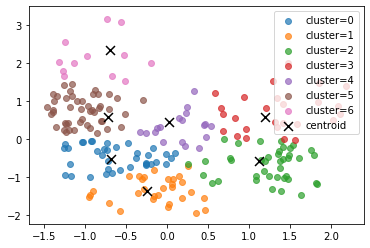

In [106]:
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt',
                   names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                          'asymmetry_coefficient', 'length_kernel_groove', 'target'], usecols=[0, 5],
                   sep='\t+', engine='python')

#data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

# Initialization and training
som_shape = (1, 7)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.9, learning_rate=.7,
              neighborhood_function='gaussian', random_seed=10)

som.train(data, 500, verbose=True)

# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

import matplotlib.pyplot as plt
%matplotlib inline

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x',
                s=80, linewidths=35, color='k', label='centroid')
plt.legend();

## Incremental Keras

In [36]:
import keras
import numpy as np
from keras.models import *
from keras.layers import *

# Create Model
model = Sequential()
model.add(Dense(128, input_shape=((1,3)), activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(3))
model.compile(loss="mse", optimizer="adam")

# Data | Train
for v in np.arange(1,350):
    seed = v
    x = np.expand_dims(np.array(np.arange(seed,seed+3)), axis=0)
    y = np.expand_dims(np.array(np.arange(seed,seed+3)*2), axis=0)
    print(model.train_on_batch(x,y))


17.952987670898438
35.842342376708984
59.87112045288086
88.55343627929688
121.11795806884766
157.06439208984375
195.6961212158203
236.0131378173828
277.6917724609375
320.3891296386719
362.8694763183594
404.095947265625
442.9117736816406
479.2541809082031
512.1069946289062
540.3278198242188
562.7633056640625
579.2692260742188
588.6337280273438
590.7573852539062
584.737060546875
569.5340576171875
544.9938354492188
510.9955139160156
467.9759521484375
414.0168762207031
353.3458557128906
289.5167236328125
225.5348663330078
165.92942810058594
115.7493667602539
79.99675750732422
61.72977828979492
61.62876892089844
76.36980438232422
99.11041259765625
118.8701171875
127.34871673583984
121.0826416015625
102.12276458740234
74.23090362548828
44.45100402832031
19.73870849609375
5.25208854675293
3.1033124923706055
11.825630187988281
26.866989135742188
42.16249084472656
52.242401123046875
53.96109390258789
47.212772369384766
34.61989974975586
20.502893447875977
9.430286407470703
4.600553512573242
6.4

In [37]:
x_hat = np.expand_dims(np.array([3, 4, 5]), axis=0)
model.predict(x_hat)


array([[8.357785 , 8.391244 , 8.4320545]], dtype=float32)

## MLP Sk Learn

In [181]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [307]:
clf = MLPClassifier(random_state=1, max_iter=200)
#https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(clf, parameter_space, n_jobs=-1, cv=3)
clf.fit(dataset.to_numpy()[:, :-1], dataset.to_numpy()[:, -1])

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
0.892 (+/-0.029) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.944 (+/-0.013) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.892 (+/-0.029) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.944 (+/-0.013) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.894 (+/-0.042) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.942 (+/-0.016) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'ada

C:\Users\MARCELO\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
clf = MLPClassifier(random_state=1, max_iter=200, activation='tanh', alpha=0.0001, hidden_layer_sizes=(100,), learning_rate='constant', solver='adam')

shape = (330,18)

data_X = np.concatenate((data['F1']))
data_Y =  np.concatenate(([0] * shape[0]))

clf.partial_fit(data_X, data_Y, classes= np.arange(0,1))

In [332]:
unknown = 0
comparative = data['FF_train']
for r in clf.predict_proba(comparative):
    if max(r) < 0.5:
        unknown = unknown+1

unknown / len(comparative)

clf.predict(comparative)
#clf.classes_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## GAN

In [1]:
# https://realpython.com/generative-adversarial-networks/
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
torch.manual_seed(111)


Bad key "text.kerning_factor" on line 4 in
C:\Users\MARCELO\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [24]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
# train_data = torch.from_numpy(data['FF'][:256,:16])
train_data_length = len(train_data)
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

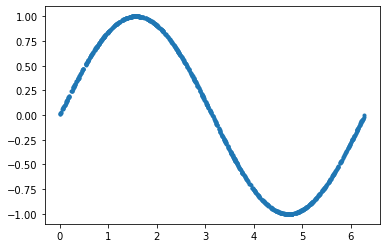

In [25]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [26]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [28]:
discriminator = Discriminator()

In [29]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [30]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [31]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [32]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):

        ###########################################
        ### Data for training the discriminator ###
        ###########################################
        real_samples_labels = torch.ones((batch_size, 1))

        # generate fake samples
        latent_space_samples = torch.randn((batch_size, 16))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))

        #merge real samples | generated fake samples
        all_samples = torch.cat((real_samples.type(torch.FloatTensor), generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        ##################################
        ### Training the discriminator ###
        ##################################
        discriminator.zero_grad()

        # discriminator real x fake
        output_discriminator = discriminator(all_samples)

        # loss calculator
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)

        # update weights
        loss_discriminator.backward()
        optimizer_discriminator.step()

        #######################################
        ### Data for training the generator ###
        #######################################
        latent_space_samples = torch.randn((batch_size, 16))

        ##############################
        ### Training the generator ###
        ##############################
        generator.zero_grad()

        # generate fake samples
        generated_samples = generator(latent_space_samples)

        # discriminator fake samples
        output_discriminator_generated = discriminator(generated_samples)

        # loss calculator
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )

        # update weights
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 2 but got size 16 for tensor number 1 in the list.

In [ ]:
latent_space_samples = torch.randn(100, 16)
generated_samples = generator(latent_space_samples)

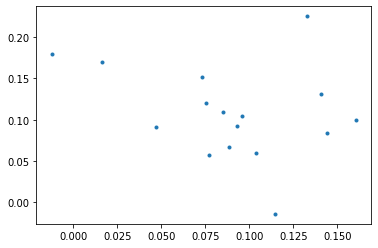

In [33]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")